## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0726 16:27:22.813529 11760 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0726 16:27:22.955393 11760 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0726 16:27:29.483852 11760 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 16:27:29.484849 11760 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 16:27:29.640434 11760 depr

Experiment with Regulizer = 0.010000


W0726 16:27:29.889901 11760 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0726 16:27:30.256919 11760 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 343us/step - loss: 15.0906 - acc: 0.2760 - val_loss: 13.9665 - val_acc: 0.3347
Epoch 2/50
50000/50000 [==============================] - 6s 128us/step - loss: 13.0277 - acc: 0.3608 - val_loss: 12.1374 - val_acc: 0.3776
Epoch 3/50
50000/50000 [==============================] - 6s 125us/step - loss: 11.3581 - acc: 0.3814 - val_loss: 10.6083 - val_acc: 0.3870
Epoch 4/50
50000/50000 [==============================] - 7s 130us/step - loss: 9.9462 - acc: 0.3967 - val_loss: 9.3132 - val_acc: 0.3986
Epoch 5/50
50000/50000 [==============================] - 7s 132us/step - loss: 8.7452 - acc: 0.4059 - val_loss: 8.2038 - val_acc: 0.4125
Epoch 6/50
50000/50000 [==============================] - 7s 134us/step - loss: 7.7224 - acc: 0.4141 - val_loss: 7.2617 - val_acc: 0.4206
Epoch 7/50
50000/50000 [==============================] - 7s 134us/step - loss: 6.8496 - acc: 0.4198 - val_loss: 6.

50000/50000 [==============================] - 7s 133us/step - loss: 2.1611 - acc: 0.2763 - val_loss: 1.9961 - val_acc: 0.3413
Epoch 2/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.9425 - acc: 0.3675 - val_loss: 1.8869 - val_acc: 0.3900
Epoch 3/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.8481 - acc: 0.4027 - val_loss: 1.8176 - val_acc: 0.4084
Epoch 4/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.7854 - acc: 0.4243 - val_loss: 1.7720 - val_acc: 0.4252
Epoch 5/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.7385 - acc: 0.4384 - val_loss: 1.7295 - val_acc: 0.4434
Epoch 6/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.7011 - acc: 0.4538 - val_loss: 1.7029 - val_acc: 0.4433
Epoch 7/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6693 - acc: 0.4645 - val_loss: 1.6704 - val_acc: 0.4593
Epoch 8/50
50000/50000 [=====================

50000/50000 [==============================] - 6s 122us/step - loss: 1.8206 - acc: 0.3631 - val_loss: 1.7679 - val_acc: 0.3864
Epoch 3/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.7375 - acc: 0.3895 - val_loss: 1.7066 - val_acc: 0.4011
Epoch 4/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.6808 - acc: 0.4102 - val_loss: 1.6575 - val_acc: 0.4176
Epoch 5/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.6337 - acc: 0.4253 - val_loss: 1.6186 - val_acc: 0.4333
Epoch 6/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.5930 - acc: 0.4406 - val_loss: 1.5800 - val_acc: 0.4436
Epoch 7/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5569 - acc: 0.4533 - val_loss: 1.5680 - val_acc: 0.4493
Epoch 8/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5262 - acc: 0.4636 - val_loss: 1.5535 - val_acc: 0.4494
Epoch 9/50
50000/50000 [=====================

50000/50000 [==============================] - 8s 157us/step - loss: 1.7176 - acc: 0.3967 - val_loss: 1.6895 - val_acc: 0.4072
Epoch 4/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.6609 - acc: 0.4157 - val_loss: 1.6443 - val_acc: 0.4210
Epoch 5/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.6134 - acc: 0.4326 - val_loss: 1.6021 - val_acc: 0.4400
Epoch 6/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.5744 - acc: 0.4476 - val_loss: 1.5712 - val_acc: 0.4422
Epoch 7/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.5414 - acc: 0.4573 - val_loss: 1.5486 - val_acc: 0.4538
Epoch 8/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.5116 - acc: 0.4670 - val_loss: 1.5327 - val_acc: 0.4517
Epoch 9/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.4865 - acc: 0.4763 - val_loss: 1.4966 - val_acc: 0.4649
Epoch 10/50
50000/50000 [====================

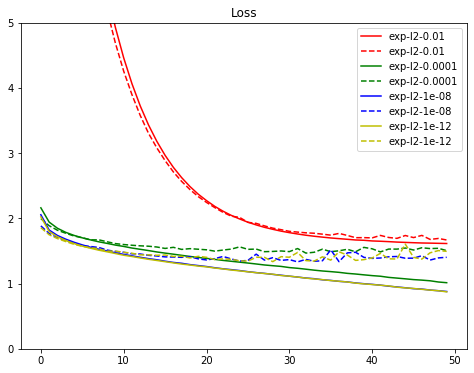

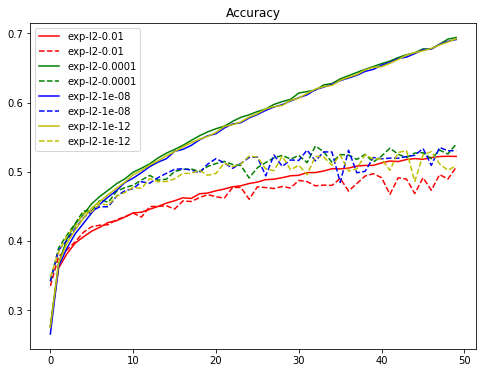

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()